In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten,Deconvolution2D,BatchNormalization,Add,Input,Concatenate,Add,Conv2DTranspose,concatenate
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import cv2
import os
print(os.listdir("../input"))
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['stage1_test', 'stage1_train_labels.csv', 'stage2_test_final', 'stage1_sample_submission.csv', 'stage1_train', 'stage2_sample_submission_final.csv']


In [2]:
img_mask_dir=glob.glob("../input/stage1_train/*")

In [3]:
imgdir=[]
for i in img_mask_dir:
    dir1=glob.glob(i+"/images/*")
    img=cv2.imread(dir1[0])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(128,128))
    imgdir.append(img)

In [4]:
maskdir=[]
for i in img_mask_dir:
    dir1=glob.glob(i+"/masks/*")
    maskimg=np.zeros((128,128))
    for j in dir1:
        
        img=cv2.imread(j)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img=cv2.resize(img,(128,128))
        maskimg=np.maximum(maskimg,img)
    
    maskdir.append(maskimg)

(128, 128, 3)

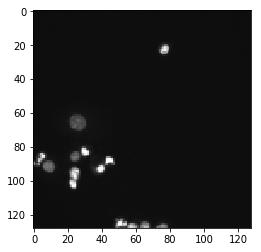

In [5]:
plt.imshow(imgdir[0])
imgdir[0].shape

(128, 128)

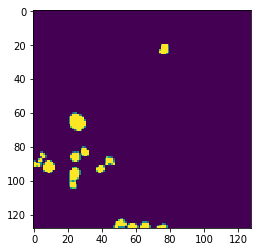

In [6]:
plt.imshow(maskdir[0])
maskdir[0].shape

In [7]:
xtrain=np.array(imgdir).astype(np.float32)/255
ytrain=np.array(maskdir).astype(np.float32)/255

In [8]:
ytrain=ytrain.reshape((-1,128,128,1))

In [9]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [10]:
inp=Input((128,128,3))
x1=Conv2D(16,3,padding='same',activation='elu',kernel_initializer='he_normal')(inp)
x1=BatchNormalization()(x1)
x1=Dropout(0.2)(x1)
x1=Conv2D(16,3,padding='same',activation='elu',kernel_initializer='he_normal')(x1)

x1=BatchNormalization()(x1)
x1=Dropout(0.2)(x1)
p1=MaxPooling2D()(x1)

inp2=Conv2D(32,3,padding='same',activation='elu',kernel_initializer='he_normal')(p1)
x2=BatchNormalization()(inp2)
x2=Dropout(0.2)(x2)
x2=Conv2D(32,3,padding='same',activation='elu',kernel_initializer='he_normal')(x2)
x2=Add()([inp2,x2])
x2=BatchNormalization()(x2)
x2=Dropout(0.2)(x2)
p2=MaxPooling2D()(x2)

inp3=Conv2D(32,3,padding='same',activation='elu',kernel_initializer='he_normal')(p2)
x3=BatchNormalization()(inp3)
x3=Dropout(0.2)(x3)
x3=Conv2D(32,3,padding='same',activation='elu',kernel_initializer='he_normal')(x3)
x3=Add()([inp3,x3])
x3=BatchNormalization()(x3)
x3=Dropout(0.2)(x3)
p3=MaxPooling2D()(x3)

inp4=Conv2D(32,3,padding='same',activation='elu',kernel_initializer='he_normal')(p3)
x4=BatchNormalization()(inp4)
x4=Dropout(0.2)(x4)
x4=Conv2D(32,3,padding='same',activation='elu',kernel_initializer='he_normal')(x4)
x4=Add()([inp4,x4])
x4=BatchNormalization()(x4)
x4=Dropout(0.2)(x4)
p4=MaxPooling2D()(x4)

x5=Conv2D(256,3,padding='same',activation='elu',kernel_initializer='he_normal')(p4)
x5=Dropout(0.2)(x5)
x5=BatchNormalization()(x5)
x5=Conv2D(256,3,padding='same',activation='elu',kernel_initializer='he_normal')(x5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (x5)
u61 = concatenate([u6, x4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u61)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
c6 = Add()([u6,c6])

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u7, x3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u71)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
c7 = Add()([u7,c7])

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u81 = concatenate([u8, x2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u81)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
c7 = Add()([u8,c8])

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u91 = concatenate([u9, x1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u91)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
c7 = Add()([u9,c9])
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [11]:
model=Model(inp,outputs)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [13]:
def loss1(ytrue,ypred):
    smooth=1
    intersection=2*K.sum(ytrue*ypred+smooth)
    a=K.sum(ytrue+ypred+smooth)
    diceloss=intersection/a
    return 0.44*K.mean(binary_crossentropy(ytrue,ypred))-(0.56*diceloss)

In [14]:
model.compile(optimizer='adam',loss=loss1,metrics=[mean_iou])

In [15]:
results = model.fit(xtrain,ytrain, validation_split=0.1, batch_size=16, epochs=200, 
                    )

Train on 603 samples, validate on 67 samples
Epoch 1/200
603/603 [==============================] - 9s 15ms/step - loss: -0.8161 - mean_iou: 0.5017 - val_loss: -0.8959 - val_mean_iou: 0.6035
Epoch 2/200
603/603 [==============================] - 2s 4ms/step - loss: -0.9090 - mean_iou: 0.6495 - val_loss: -0.8944 - val_mean_iou: 0.6808
Epoch 3/200
603/603 [==============================] - 2s 4ms/step - loss: -0.9204 - mean_iou: 0.6976 - val_loss: -0.8888 - val_mean_iou: 0.7130
Epoch 4/200
603/603 [==============================] - 2s 4ms/step - loss: -0.9323 - mean_iou: 0.7250 - val_loss: -0.9053 - val_mean_iou: 0.7367
Epoch 5/200
603/603 [==============================] - 2s 4ms/step - loss: -0.9358 - mean_iou: 0.7452 - val_loss: -0.9372 - val_mean_iou: 0.7539
Epoch 6/200
603/603 [==============================] - 2s 4ms/step - loss: -0.9394 - mean_iou: 0.7600 - val_loss: -0.9123 - val_mean_iou: 0.7663
Epoch 7/200
603/603 [==============================] - 2s 4ms/step - loss: -0.9391 -

In [16]:
pred=model.predict(xtrain)

In [17]:
pred1=(pred>0.52)*1.0

In [18]:
y1=(pred[1]>0.5)*1.0  # we can use thresholding to get better predictions

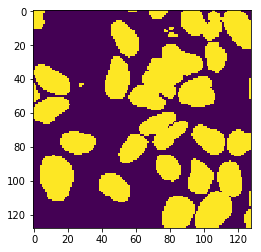

In [19]:
plt.imshow(y1.reshape((128,128)))

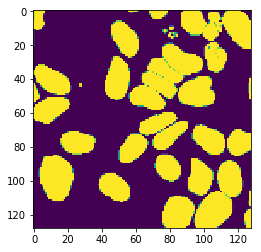

In [20]:
plt.imshow(maskdir[1])

In [21]:
ytrain1=(ytrain>0.5)*1.0

In [22]:
ytrain1.shape

(670, 128, 128, 1)

In [23]:
pred.shape

(670, 128, 128, 1)

In [24]:
# https://swarbrickjones.wordpress.com/2017/03/28/cross-entropy-and-training-test-class-imbalance/

In [25]:
# https://gchlebus.github.io/2018/02/18/semantic-segmentation-loss-functions.html

In [26]:
x=2*np.sum(pred1*ytrain1)

In [27]:
dicescore=x/(np.sum(pred1)+np.sum(ytrain1))

In [28]:
dicescore

0.9569914490041093

In [29]:
dicescore

0.9569914490041093

In [30]:
x=np.linspace(0.20,0.60,100)

In [31]:
x

array([0.2       , 0.2040404 , 0.20808081, 0.21212121, 0.21616162,
       0.22020202, 0.22424242, 0.22828283, 0.23232323, 0.23636364,
       0.24040404, 0.24444444, 0.24848485, 0.25252525, 0.25656566,
       0.26060606, 0.26464646, 0.26868687, 0.27272727, 0.27676768,
       0.28080808, 0.28484848, 0.28888889, 0.29292929, 0.2969697 ,
       0.3010101 , 0.30505051, 0.30909091, 0.31313131, 0.31717172,
       0.32121212, 0.32525253, 0.32929293, 0.33333333, 0.33737374,
       0.34141414, 0.34545455, 0.34949495, 0.35353535, 0.35757576,
       0.36161616, 0.36565657, 0.36969697, 0.37373737, 0.37777778,
       0.38181818, 0.38585859, 0.38989899, 0.39393939, 0.3979798 ,
       0.4020202 , 0.40606061, 0.41010101, 0.41414141, 0.41818182,
       0.42222222, 0.42626263, 0.43030303, 0.43434343, 0.43838384,
       0.44242424, 0.44646465, 0.45050505, 0.45454545, 0.45858586,
       0.46262626, 0.46666667, 0.47070707, 0.47474747, 0.47878788,
       0.48282828, 0.48686869, 0.49090909, 0.49494949, 0.49898

In [32]:
y=[]
for i in x:
    pred1=(pred>i)*1.0
    x1=2*np.sum(pred1*ytrain1)
    dicescore=x1/(np.sum(pred1)+np.sum(ytrain1))
    y.append(dicescore)

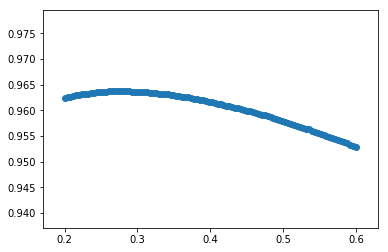

In [33]:
plt.scatter(x,y)

In [34]:
y[0]

0.9623531490708513

In [35]:
#best threshold

indx=np.argmax(y)

In [36]:
bestthreshold=x[indx]

In [37]:
bestthreshold

0.2727272727272727

In [38]:
y[indx]

0.963736632881938